In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 25.2MB/s 
     |████████████████████████████████| 3.3MB 32.3MB/s 
     |████████████████████████████████| 901kB 31.3MB/s 


In [ ]:
%matplotlib inline
import tensorflow as tf
import torch
import os
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer
from transformers import get_linear_schedule_with_warmup
import time
import datetime
from sklearn.model_selection import train_test_split
import random
import re
import matplotlib
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertModel, BertPreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput
from torch import nn
from torch.nn import BCEWithLogitsLoss
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from sklearn.model_selection import StratifiedKFold
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def clean_text(text):
  text = text.lower()
  text = re.sub(r"what's", "what is ", text)
  text = re.sub(r"\'s", " ", text)
  text = re.sub(r"’", "'", text)
  text = re.sub(r"\'ve", " have ", text)
  text = re.sub(r"can't", "can not ", text)
  text = re.sub(r"haven't", "have not ", text)
  text = re.sub(r"don't", "do not ", text)
  text = re.sub(r"wouldn't", "would not ", text)
  text = re.sub(r"i'm", "i am ", text)
  text = re.sub(r"\'re", " are ", text)
  text = re.sub(r"\'d", " would ", text)
  text = re.sub('2', 'two', text)
  text = re.sub(r"\'ll", " will ", text)
  text = re.sub(r"\'scuse", " excuse ", text)
  text = re.sub(r'says, "', 'says: "', text)
  text = re.sub("in'", 'ing', text)
  text = text.replace("\n", "")
  text = text.replace("\t", "")
  text = text.strip(' ')
  return text


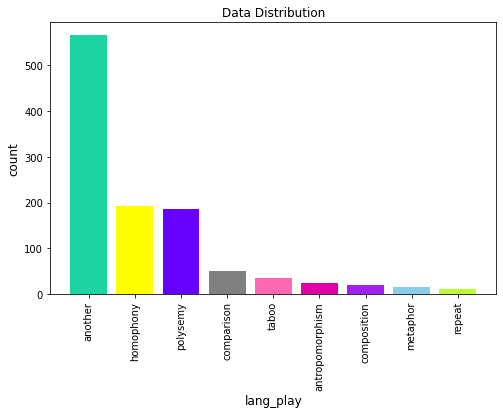

Number of unique text_structure_labels: 9
Number of training sentences: 1,099

another            565
homophony          192
polysemy           185
comparison          50
taboo               35
antropomorphism     24
composition         21
metaphor            15
repeat              12
Name: lang_play, dtype: int64
Index(['joke', 'another', 'antropomorphism', 'comparison', 'composition',
       'homophony', 'metaphor', 'polysemy', 'repeat', 'taboo'],
      dtype='object', name='lang_play')
{'another': 1, 'antropomorphism': 2, 'comparison': 3, 'composition': 4, 'homophony': 5, 'metaphor': 6, 'polysemy': 7, 'repeat': 8, 'taboo': 9}


In [ ]:
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQfFx3TMpHYWKXAiExoDC4qFpYal1n_y8yLAfQTHpUOCVFw67uukmf5rFd60McXEM0L6-vilYw2UK_q/pub?gid=0&single=true&output=csv")
def prepare_df(df):
  df = df.dropna()
  df = df.drop_duplicates(['joke'])
  df['joke'] = df['joke'].map(lambda joke : clean_text(joke))
  df["lang_play_two"] = df["lang_play"]
  #df["humor_type"] = df["lang_play"]
  df.loc[df['lang_play'].str.contains('homonymy', regex=True), "lang_play"] = "polysemy"
  df.loc[df['lang_play'].str.contains('homophorm', regex=True), "lang_play"] = "homophony"
  df.loc[df['lang_play_two'].str.contains('metaphor|comparison|repeat|antropomorphism', regex=True), "lang_play_two"] = "stylistic"
  df.loc[df['lang_play_two'].str.contains('another|taboo', regex=True), "lang_play_two"] = "another"
  df.loc[df['lang_play_two'].str.contains('homo\w*|polysemy|acronym|synonymy|composition|semantics|syntax|archaism', regex=True), "humor_type"] = "lexico-phonetic"
  #df = df[df['lang_play'] != 'another'] для анализа узконаправленных типов языковой игры

  ######Для анализа типа юмора
  #df["humor_type"] = df["lang_play"]
  #df.loc[df['humor_type'].str.contains('another|taboo', regex=True), "humor_type"] = "referential"
  #df.loc[df['humor_type'].str.contains('homo\w*|polysemy|acronym|synonymy|composition|semantics|syntax|archaism|metaphor|comparison|repeat|antropomorphism', regex=True), "humor_type"]
  
  ######Для аннализа синтаксической структуры юмора
  #df["text_structure"] = df["text_structure"].replace('\nquestion-answer', 'question-answer')
  return df

df = prepare_df(df)

cat_types = df["lang_play"].value_counts().to_dict()
plt.figure(figsize=(8,5))
plt.bar(cat_types.keys(), cat_types.values(), color = ['#1cd3a2', '#ffff00', '#6600ff', "#808080",'#ff69b4','#e100a5','#a020f0', 
     '#87ceeb', '#bbfd30', '#bb425b', 
     '#bbade2', '#bbf20d',  '#bb248b'])

plt.xticks(rotation= 'vertical')
plt.title("Data Distribution")
plt.ylabel('count', fontsize=12)
plt.xlabel('lang_play', fontsize=12)
plt.show()

#def prepare_df(df):
print('Number of unique text_structure_labels: {}'.format(len(list(set(df["lang_play"].to_list())))))
print('Number of training sentences: {:,}\n'.format(len(df.drop_duplicates(['joke']))))
#print(label_dict)
print(df["lang_play"].value_counts())
df = df.drop_duplicates(['joke'])
df["lang_play_two"] = df["lang_play"]
#df["lang_play_two"] = df["lang_play_two"].replace(label_dict)
df["labels"] = 1
df = df.pivot(index='joke', columns='lang_play', values="labels").reset_index()
df = df.fillna(np.float64(0))
print(df.columns)
#df["stylistic"] = [int(i) for i in df["stylistic"]]
#df["lexico-phonetic"] = [int(i) for i in df["lexico-phonetic"]]
#for col in df.columns[1:]:
#  df[col] = [np.float64(i) for i in df[col]]
#print(type(df["taboo"][0]))

categories = [i for i in df.columns[1:]]
uniq_class = [i for i in range(1, len(categories)+ 1)]
label_dict = {i:k for i,k in zip(categories, uniq_class)}
df.sample()
df.head(10)
print(label_dict)
#df.to_csv("nw.csv")
#
#return df, categories


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))

if torch.cuda.is_available():      
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:

def train_test_split_data(df, test_size):
  train, test = train_test_split(df, random_state=42, test_size=None, shuffle=True)
  #skf = StratifiedKFold(n_splits=2, random_state=42)
  #train, test = skf.split(df.joke, df.labels)
  return train, test

In [ ]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Loading BERT tokenizer...


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
def prepare_data(sentences,tokenizer):
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in tqdm(sentences, total=len(sentences)):
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 512,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  #labels = torch.tensor(labels)

  return input_ids, attention_masks

In [ ]:
def format_time(
    elapsed
):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def eval_result(target, predict):
  print('Test Accuracy is {}'.format(accuracy_score(target, predict)))
  print('Test F1 is {}'.format(f1_score(target, predict, average='weighted')))
  print('Test Precision is {}'.format(precision_score(target, predict, average= 'weighted')))
  print('Test Recall is {}'.format(recall_score(target, predict, average='weighted')))
  #print('Test for all classes {}').format(classification_report(target, predict, target_names=[0, 1, 2]))

In [ ]:
class BertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config, num_classes):
        super().__init__(config)
        self.config = config

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_classes)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )



In [ ]:
# prepare input: cut and pad

train, test = train_test_split_data(df, test_size=0.33)
#test, val = train_test_split_data(test_val, test_size=0.5)
train_joke = train.joke
test_joke = test.joke
train_input_ids, train_attention_masks = prepare_data(sentences = train_joke, tokenizer=tokenizer)
test_input_ids, test_attention_masks = prepare_data(sentences= test_joke, tokenizer=tokenizer)
#val_input_ids, val_attention_masks
train.shape
#input_ids, attention_masks, labels = prepare_data(sentences= df["joke"], labels=df["lang_play_two"], tokenizer=tokenizer)


  0%|          | 0/399 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 134/134 [00:00<00:00, 1014.12it/s]


(399, 9)

In [ ]:
def prepare_dataloader_train(train, train_input_ids, train_attention_masks, labels, batch_size):
  train_inputs = torch.tensor(train_input_ids)
  train_masks = torch.tensor(train_attention_masks)
  train_labels = torch.tensor(train[labels].to_numpy(), dtype = torch.float)
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  dataloader_train = DataLoader(train_data, 
                                sampler=RandomSampler(train_data), 
                                batch_size=batch_size)
  return dataloader_train

def prepare_dataloader_validation(test, test_input_ids, test_attention_masks, labels, batch_size):
  test_inputs = torch.tensor(test_input_ids)
  test_masks = torch.tensor(test_attention_masks)
  test_labels = torch.tensor(test[labels].to_numpy(), dtype = torch.float)
  test_data = TensorDataset(test_inputs, test_masks, test_labels)
  dataloader_val = DataLoader(test_data, 
                              sampler=SequentialSampler(test_data), 
                              batch_size=batch_size)
  return dataloader_val

In [ ]:
dataloader_train = prepare_dataloader_train(
    train = train, train_input_ids=train_input_ids, train_attention_masks=train_attention_masks, labels=categories, batch_size=12)
dataloader_val = prepare_dataloader_validation(
    test=test, test_input_ids=test_input_ids, test_attention_masks=test_attention_masks,  labels=categories, batch_size=12)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor,

In [ ]:
batch_size=32
epochs=5 #1
seed_val=42
device = device
random.seed(seed_val)
np.random.seed(seed_val)
#torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model = BertForSequenceClassification.from_pretrained(
        "bert-base-cased",
        output_attentions=False,
        output_hidden_states=True,
        num_classes=len(categories)
    )

model = model.to(device)

optimizer = AdamW(
    model.parameters(),
    lr=2e-5, 
    eps=1e-8
)

total_steps = len(dataloader_train) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=50, # Default value in run_glue.py
    num_training_steps=total_steps
)

loss_train, loss_valid = [], []

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
#val_loss, predictions, true_vals = evaluate(dataloader_val)
def evaluate(dataloader_val):
    t0 = time.time()
    test_targets, test_pred_class = [], []
    model.eval()
    nb_eval_steps, nb_eval_examples = 0, 0
    valid_loss = 0
    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():        
          outputs = model(
              b_input_ids,
              token_type_ids=None,
              attention_mask=b_input_mask,
              labels=b_labels
          )
        loss, logits = outputs[:2]
        valid_loss += loss.item()
        loss_valid.append(loss)

        logits = logits.detach()
        probs = nn.Sigmoid()(logits).cpu().numpy()
        label_ids = b_labels.detach().cpu().numpy()
        classes = np.where(probs > 0.5, 1., 0.)
        test_pred_class.append(label_ids)
        test_targets.append(classes)
        nb_eval_steps += 1
    avg_valid_loss = valid_loss/len(dataloader_val) 
    
    test_pred_class = np.concatenate(test_pred_class, axis=0)
    test_targets = np.concatenate(test_targets, axis=0)
            
    return avg_valid_loss, loss_valid, test_pred_class, test_targets

In [ ]:
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i, epochs))
    print('Training...')
    total_loss = 0
    model.train()
    with tqdm(dataloader_train, total=len(dataloader_train), unit="batch") as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch_i}")
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            model.zero_grad()
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels
            )
            loss = outputs[0]
            total_loss += loss.item()
            loss.backward()
            loss_train.append(loss.item())
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            tepoch.set_postfix(loss=loss.item())
    avg_valid_loss, loss_valid, test_pred_class, test_targets = evaluate(dataloader_val)
        

    print("")
    print("  Average valid loss: {0:.2f}".format(avg_valid_loss))

    eval_result(test_targets.squeeze().flatten(), test_pred_class.squeeze().flatten())


    print("")
    print("Training complete!")
    
    plt.plot(loss_train)
    plt.title('Train loss')
    plt.show()
    
    plt.plot(loss_valid)
    plt.title('Valid loss')
    plt.show()

Epoch 0:   0%|          | 0/34 [00:00<?, ?batch/s]


======== Epoch 0 / 5 ========
Training...


Epoch 0:   3%|▎         | 1/34 [00:02<01:19,  2.40s/batch, loss=0.777]


RuntimeError: ignored

In [ ]:
#####Roc-auc
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
num_labels=len(categories)

for i in range(0, num_labels):
    fpr[i], tpr[i], _ = roc_curve(test_targets[:, i], test_pred_class[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_targets.ravel(), test_pred_class.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

result = {'roc_auc': roc_auc}
print(result)

In [ ]:
list(label_dict.values())

In [ ]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, classification_report,ConfusionMatrixDisplay, confusion_matrix
cm=multilabel_confusion_matrix(test_targets, test_pred_class)
print(cm)
f, axes = plt.subplots(1, len(categories), figsize=(25, 5))
labels= list(label_dict.values())
axes = axes.ravel()
for i, category in enumerate(categories):
    disp = ConfusionMatrixDisplay(confusion_matrix(test_targets[:, i],
                                                   test_pred_class[:, i]),
                                  display_labels=[0,1])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {category}')
    if i<8:
        disp.ax_.set_xlabel('')
    if i%8!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.5, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [ ]:

#torch.save(model.state_dict(), "./saved_model/finetuned_BERT_epoch_1")

In [ ]:
#########Log-regression


#train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)
train_set = train.joke
test_set = test.joke


LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=3)),
            ])
all_predictions = []
all_targets = []
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(train_set, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(test_set)
    eval_result(test[category], prediction)
    all_predictions.append(prediction) 
    all_targets.append(test[category])
print("... Overall metrics")
eval_result(
    [value for pred_col in all_predictions for value in pred_col], 
    [value for pred_col in all_targets for value in pred_col]
)


In [ ]:
train_set = train.joke
test_set = test.joke
f, axes = plt.subplots(1, len(categories), figsize=(25, 5))
labels= list(label_dict.values())
axes = axes.ravel()

LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=3)),
            ])
all_predictions = []
all_targets = []
for i, category in enumerate(categories):
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(train_set, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(test_set)
    disp = ConfusionMatrixDisplay(confusion_matrix(test[category],
                                                   prediction),
                                  display_labels=[0,1])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {category}')
    if i<8:
        disp.ax_.set_xlabel('')
    if i%8!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.5, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [ ]:
!ls

sample_data
